In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Для красивых графиков
sns.set(style="whitegrid")
%matplotlib inline

### Прочтём данные

In [2]:
# Загрузка данных
df_trans = pd.read_parquet("../data/transaction_fraud_data.parquet")
df_rates = pd.read_parquet("../data/historical_currency_exchange.parquet")

In [3]:
# Информация о транзакциях
print("Размер набора транзакций:", df_trans.shape)
display(df_trans.info())
display(df_trans.head(5))

print("Размер таблицы валют:", df_rates.shape)
display(df_rates.info())
display(df_rates.head(5))

Размер набора транзакций: (7483766, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7483766 entries, 0 to 7483765
Data columns (total 23 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   transaction_id           object        
 1   customer_id              object        
 2   card_number              int64         
 3   timestamp                datetime64[us]
 4   vendor_category          object        
 5   vendor_type              object        
 6   vendor                   object        
 7   amount                   float64       
 8   currency                 object        
 9   country                  object        
 10  city                     object        
 11  city_size                object        
 12  card_type                object        
 13  is_card_present          bool          
 14  device                   object        
 15  channel                  object        
 16  device_fingerprint       object 

None

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,...,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,...,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 334...",False
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,...,False,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,"{'num_transactions': 509, 'total_amount': 2011...",True
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,...,False,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,False,False,False,"{'num_transactions': 332, 'total_amount': 3916...",False
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,Australia,...,False,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,False,False,False,"{'num_transactions': 764, 'total_amount': 2201...",False
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,...,False,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,True,False,False,"{'num_transactions': 218, 'total_amount': 4827...",True


Размер таблицы валют: (31, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    31 non-null     object 
 1   AUD     31 non-null     float64
 2   BRL     31 non-null     float64
 3   CAD     31 non-null     float64
 4   EUR     31 non-null     float64
 5   GBP     31 non-null     float64
 6   JPY     31 non-null     float64
 7   MXN     31 non-null     float64
 8   NGN     31 non-null     float64
 9   RUB     31 non-null     float64
 10  SGD     31 non-null     float64
 11  USD     31 non-null     int64  
dtypes: float64(10), int64(1), object(1)
memory usage: 3.0+ KB


None

,date,AUD,BRL,CAD,EUR,GBP,JPY,MXN,NGN,RUB,SGD,USD
0,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.736400,94.133735,1.280156,1
1,2024-10-01,1.442917,5.444170,1.352168,0.897557,0.746956,143.831429,19.667561,1670.694524,92.898519,1.284352,1
2,2024-10-02,1.449505,5.425444,1.348063,0.903056,0.752241,143.806861,19.606748,1669.653006,94.583198,1.286983,1
3,2024-10-03,1.456279,5.442044,1.351451,0.906018,0.754584,146.916773,19.457701,1670.097873,95.655442,1.294391,1
4,2024-10-04,1.460930,5.477788,1.355260,0.906452,0.761891,146.592323,19.363467,1649.763738,94.755337,1.296800,1


Видно, что данных довольно много, и все признаки имеют ожидаемые типы (например, timestamp – метка времени, amount – float сумма, категориальные признаки – строки, is_fraud – bool). Пропуски, судя по info(), отсутствуют или их крайне мало – большинство столбцов заполнены полностью.

In [4]:
# Разворачивание вложенных показателей last_hour_activity
last_hour_df = pd.json_normalize(df_trans['last_hour_activity'])
last_hour_df.columns = [f"last_hour_{c}" for c in last_hour_df.columns]
df_trans = df_trans.drop(columns=['last_hour_activity']).join(last_hour_df)

# Добавляем дату транзакции и конвертируем сумму в USD
df_trans['date'] = df_trans['timestamp'].dt.date
# Преобразуем таблицу курсов валют в длинный формат для мержа
rates_long = df_rates.melt(id_vars='date', var_name='currency', value_name='rate')
df_trans = df_trans.merge(rates_long, on=['date', 'currency'], how='left')
df_trans['amount_usd'] = df_trans['amount'] * df_trans['rate']



In [5]:
print("Размер набора после добавления признаков:", df_trans.shape)
display(df_trans[['amount','currency','amount_usd','is_fraud']].head(5))
print("Процент мошеннических транзакций: {:.2%}".format(df_trans['is_fraud'].mean()))

Размер набора после добавления признаков: (7483766, 30)


,amount,currency,amount_usd,is_fraud
0,294.87,GBP,2.203131e+02,False
1,3368.97,BRL,1.830917e+04,True
2,102582.38,JPY,1.462551e+07,False
3,630.60,AUD,9.103682e+02,False
4,724949.27,NGN,1.209749e+09,True


Процент мошеннических транзакций: 19.97%


В нашем датасете примерно 7483766 транзакций, из них около 19.97% мошеннических, что свидетельствует о дисбалансе классов, который нужно учитывать при дальнейшем анализе и моделировании.

### Разведочный анализ данных

Начнём с анализа распределения сумм покупок. Посмотрим на статистику и гистограмму поля amount_usd (сумма в USD) для понимания общего разброса транзакций, а также сравним мошеннические и нормальные транзакции по этому показателю.

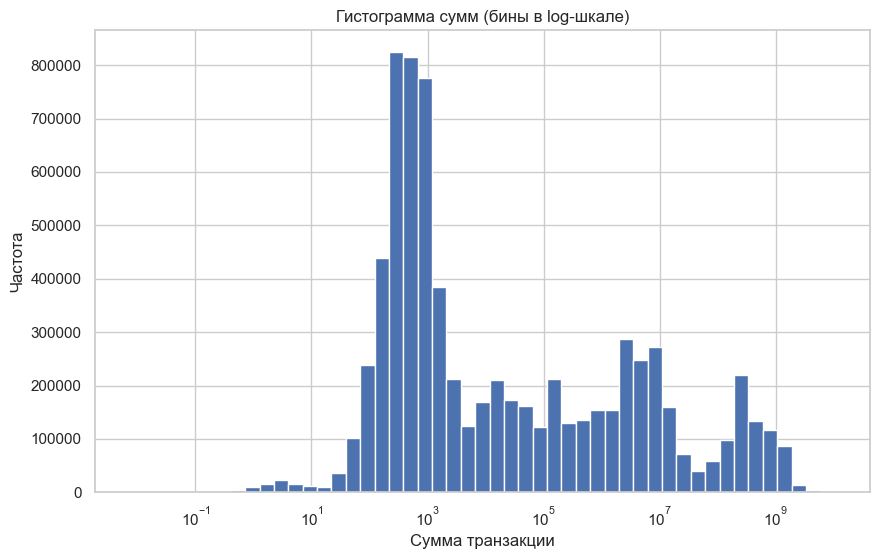

In [8]:
min_val = df_trans.loc[df_trans['amount_usd']>0, 'amount_usd'].min()
max_val = df_trans['amount_usd'].max()
bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)

plt.figure(figsize=(10,6))
plt.hist(df_trans['amount_usd'], bins=bins)
plt.xscale('log')
plt.title("Гистограмма сумм (бины в log-шкале)")
plt.xlabel("Сумма транзакции")
plt.ylabel("Частота")
plt.show()


Ядро транзакций лежит в диапазоне 10–10 000 USD, однако есть большое количество редких, но очень крупных платежей.

C:\Users\maxnn\AppData\Local\Temp\ipykernel_26424\3099344392.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate = df_trans.groupby('amount_range')['is_fraud'].mean().sort_index()


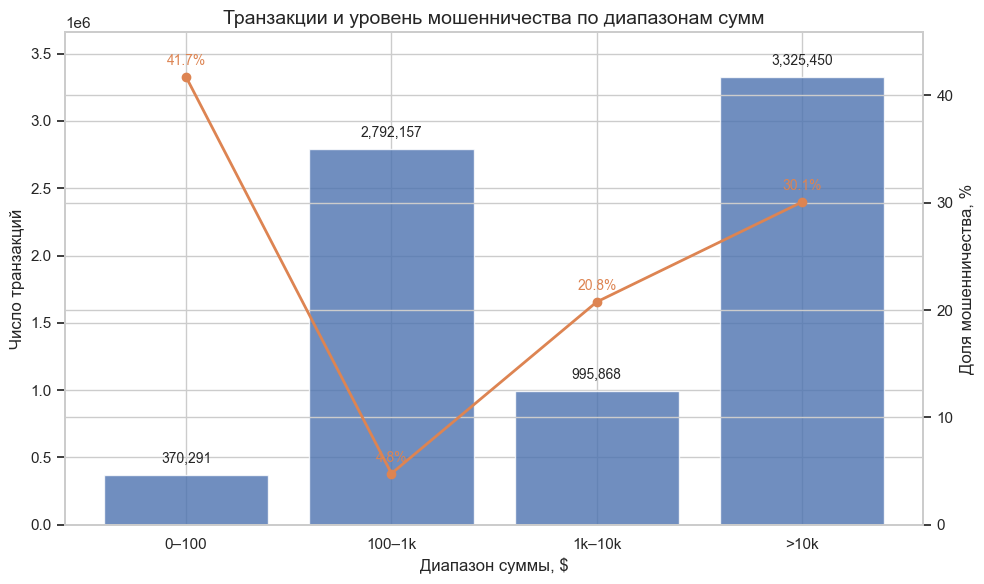

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Сегментация по диапазонам сумм
bins = [0, 100, 1000, 10000, float('inf')]
labels = ['0–100', '100–1k', '1k–10k', '>10k']
df_trans['amount_range'] = pd.cut(df_trans['amount_usd'], bins=bins, labels=labels)

# 2. Подсчёт числа транзакций и уровня мошенничества
counts = df_trans['amount_range'].value_counts().sort_index()
fraud_rate = df_trans.groupby('amount_range')['is_fraud'].mean().sort_index()

# 3. Построение графика
fig, ax1 = plt.subplots(figsize=(10, 6))

# Столбцы — число транзакций
bar_color = '#4C72B0'
bars = ax1.bar(counts.index, counts.values, color=bar_color, alpha=0.8)
ax1.set_ylabel('Число транзакций', fontsize=12)
ax1.set_xlabel('Диапазон суммы, $', fontsize=12)
ax1.set_ylim(0, counts.max() * 1.1)
ax1.tick_params(axis='x', rotation=0, labelsize=11)
ax1.tick_params(axis='y', labelsize=11)

# Добавим подписи над столбцами
for idx, val in enumerate(counts.values):
    ax1.text(idx, val + counts.max()*0.02, f"{val:,}", 
             ha='center', va='bottom', fontsize=10)

# Линия — доля мошенничества в процентах
ax2 = ax1.twinx()
line_color = '#DD8452'
ax2.plot(fraud_rate.index, fraud_rate.values * 100,
         marker='o', linestyle='-', linewidth=2, color=line_color)
ax2.set_ylabel('Доля мошенничества, %', fontsize=12)
ax2.set_ylim(0, fraud_rate.max() * 100 * 1.1)
ax2.tick_params(axis='y', labelsize=11)

# Подписи точек линии
for idx, val in enumerate(fraud_rate.values * 100):
    ax2.text(idx, val + fraud_rate.max()*100*0.02, f"{val:.1f}%",
             ha='center', va='bottom', fontsize=10, color=line_color)

# Заголовок и финальный вид
plt.title('Транзакции и уровень мошенничества по диапазонам сумм', fontsize=14)
plt.tight_layout()
plt.show()



Большая сумма транзакций (более 2,7 млн) приходится на диапазон 100–1 000 USD, при этом риск мошенничества в этом сегменте минимален (примерно 4,8%). Самый высокий риск — в диапазоне 0–100 USD (41,7%), однако общая сумма там минимальная. Тревожнее всего выяглядят транзакции более 10к долларов, так как на эту часть приходится наибольшая общая сумма транзакций (более 2,7 млн) и при этом достаточно большой проент мошенничества (примерно 30%).

Вывод:
Для малых и крупных сумм требуется усиленное внимание: для первых — возможно автоматическое отклонение при подозрениях (часто массовый фрод), для вторых — обязательная ручная проверка или повышенный скоринг.

In [11]:
 df_trans['country'].value_counts()

country
Nigeria      849840
Brazil       804800
Russia       793730
Mexico       785704
Singapore    588668
France       541287
UK           538493
Canada       532632
Japan        527393
Germany      524464
USA          500060
Australia    496695
Name: count, dtype: int64

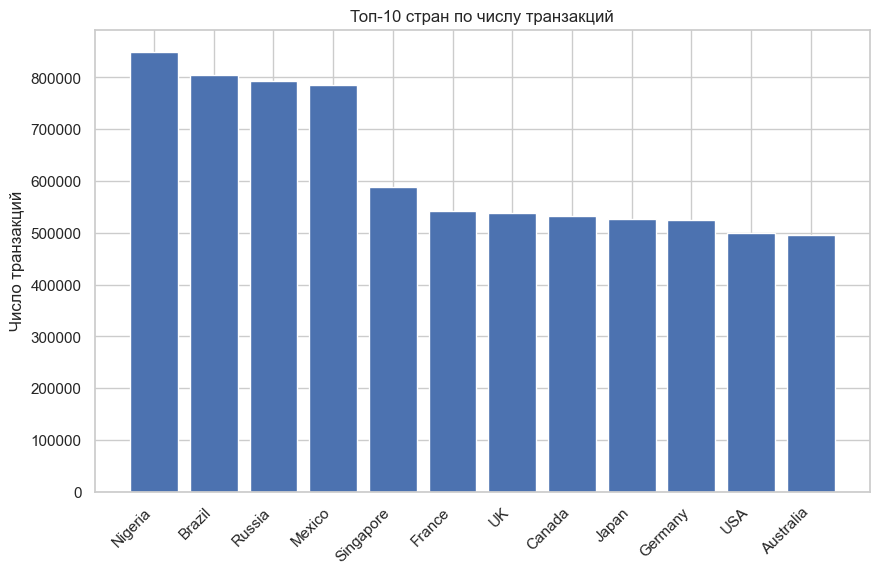

In [35]:
country_counts = df_trans['country'].value_counts().head(30)
plt.figure(figsize=(10,6))
plt.bar(country_counts.index, country_counts.values)
plt.title("Топ-10 стран по числу транзакций")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Число транзакций")
plt.show()


Активность пользователей сконцентрирована в странах с развивающимися рынками (Nigeria, Brazil, Russia, Mexico), а не только в развитых экономиках. Это говорит о необходимости локализации antifraud-политик и, возможно, отдельных продуктовых решений для разных стран

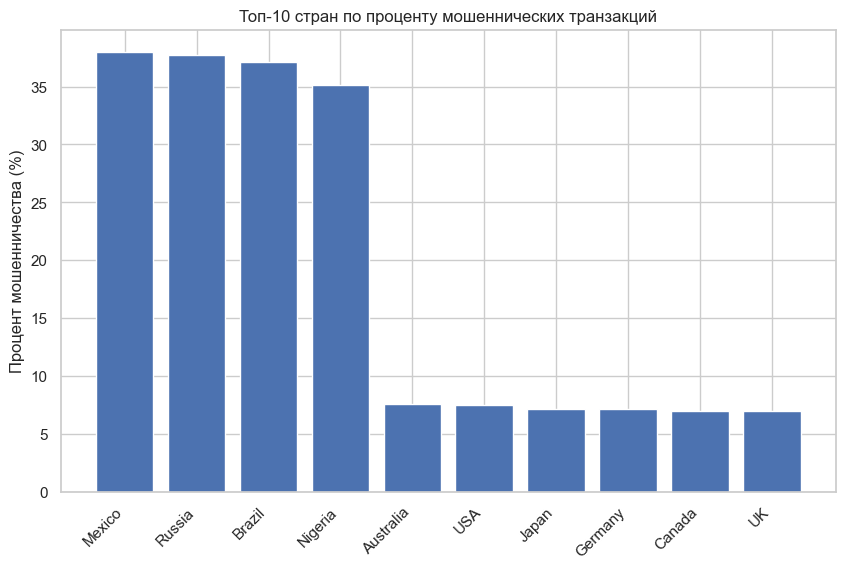

In [36]:
# Считаем общее число транзакций и мошеннических транзакций по каждой стране
country_total = df_trans.groupby('country').size()
country_fraud = df_trans[df_trans['is_fraud'] == True].groupby('country').size()

# Процент мошенничества
fraud_rate = (country_fraud / country_total).fillna(0) * 100

# Топ-10 по проценту мошенничества
top_fraud_rate = fraud_rate.sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.bar(top_fraud_rate.index, top_fraud_rate.values)
plt.title("Топ-10 стран по проценту мошеннических транзакций")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Процент мошенничества (%)")
plt.show()


Страны-лидеры по числу операций не всегда лидируют по проценту мошенничества. В Мексике, России, Бразилии, Нигерии риск мошенничества превышает 35%  — это крайне высокий показатель, требующий индивидуальных процедур контроля, ужесточения правил.
При этом несмотря на то, большое количество транзакций в США, Японии, Германии и Канаде уровень фрода минимален.

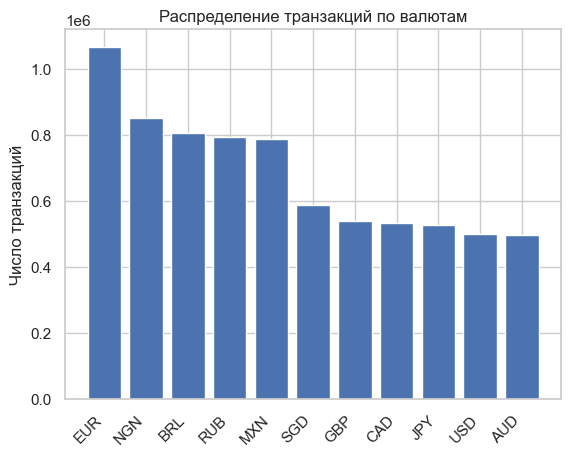

In [13]:
currency_counts = df_trans['currency'].value_counts()
plt.figure()
plt.bar(currency_counts.index, currency_counts.values)
plt.title("Распределение транзакций по валютам")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Число транзакций")
plt.show()

EUR, NGN (нигерийская найра) и BRL (бразильский реал) — лидеры по числу операций, USD — далеко не самая массовая валюта. Это подтверждает глобальность платформы и необходимость корректного учёта курсов валют в моделях (например, для оценки аномалий по суммам).

In [14]:
# Топ-10 категорий по числу транзакций
category_counts = df_trans['vendor_category'].value_counts().head(10)
print("Топ-10 категорий по количеству транзакций:")
print(category_counts)

# Доля мошенничества по категориям
fraud_rate_by_cat = df_trans.groupby('vendor_category')['is_fraud'].mean().sort_values(ascending=False)
print("Доля мошеннических транзакций по категориям:")
print(fraud_rate_by_cat)

Топ-10 категорий по количеству транзакций:
vendor_category
Healthcare       936770
Restaurant       936178
Entertainment    936173
Retail           935883
Travel           935790
Gas              935401
Grocery          934029
Education        933542
Name: count, dtype: int64
Доля мошеннических транзакций по категориям:
vendor_category
Travel           0.200341
Grocery          0.200194
Gas              0.199731
Restaurant       0.199696
Entertainment    0.199632
Education        0.199459
Retail           0.199398
Healthcare       0.199376
Name: is_fraud, dtype: float64


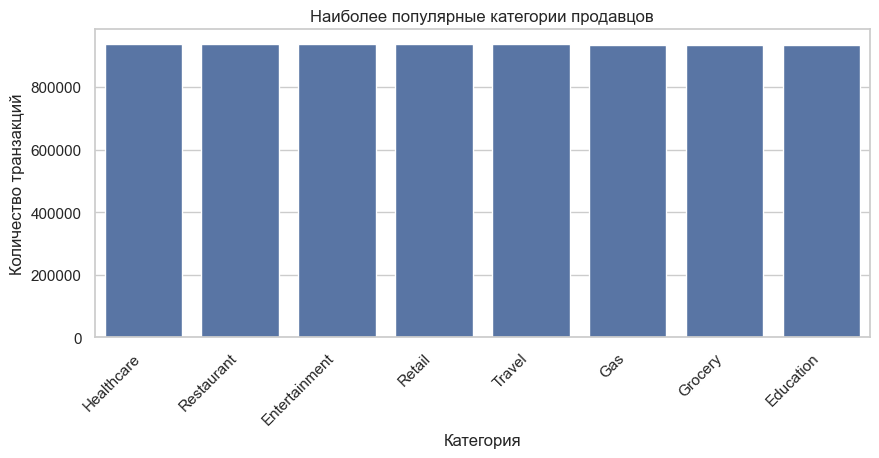

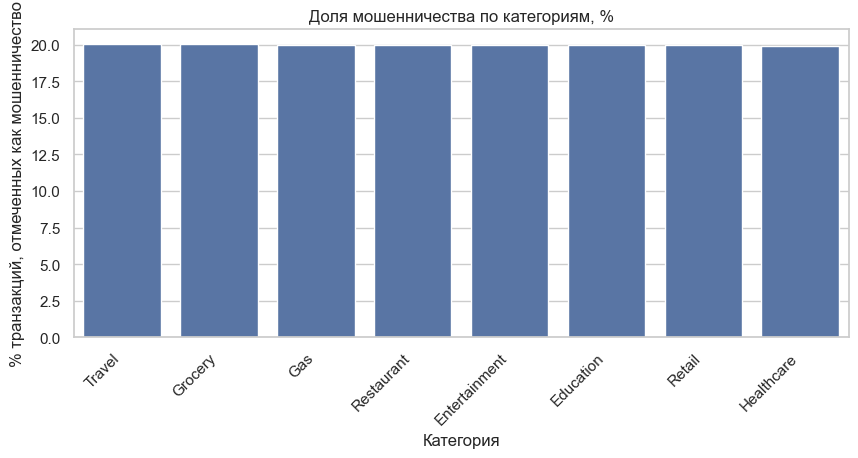

In [15]:
# График: количество транзакций по категориям
plt.figure(figsize=(10,4))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title("Наиболее популярные категории продавцов")
plt.ylabel("Количество транзакций")
plt.xlabel("Категория")
plt.xticks(rotation=45, ha='right')
plt.show()

# График: уровень мошенничества по категориям
plt.figure(figsize=(10,4))
sns.barplot(x=fraud_rate_by_cat.index, y=fraud_rate_by_cat.values*100)
plt.title("Доля мошенничества по категориям, %")
plt.ylabel("% транзакций, отмеченных как мошенничество")
plt.xlabel("Категория")
plt.xticks(rotation=45, ha='right')
plt.show()


Активность по категориям примерно равномерна — это указывает на широкий охват бизнеса (retail, travel, healthcare и др.). Однако уровень мошенничества стабильно высок во всех категориях. Значит, признак категории менее информативен для модели antifraud — стоит искать паттерны внутри категорий или по другим признакам

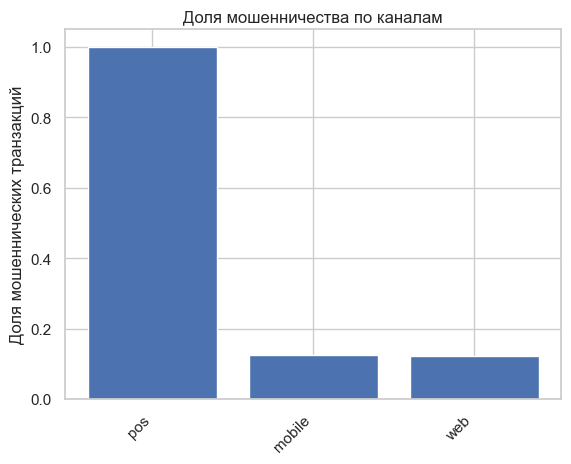

In [17]:
fraud_by_channel = df_trans.groupby('channel')['is_fraud'].mean().sort_values(ascending=False)
plt.figure()
plt.bar(fraud_by_channel.index, fraud_by_channel.values)
plt.title("Доля мошенничества по каналам")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Доля мошеннических транзакций")
plt.show()

POS (физические терминалы) неожиданно демонстрируют самую высокую долю фрода. Это может быть связано с особенностями меток или атаками на оффлайн-терминалы (например, скимминг, подделка карт). Mobile и Web — заметно менее рискованные

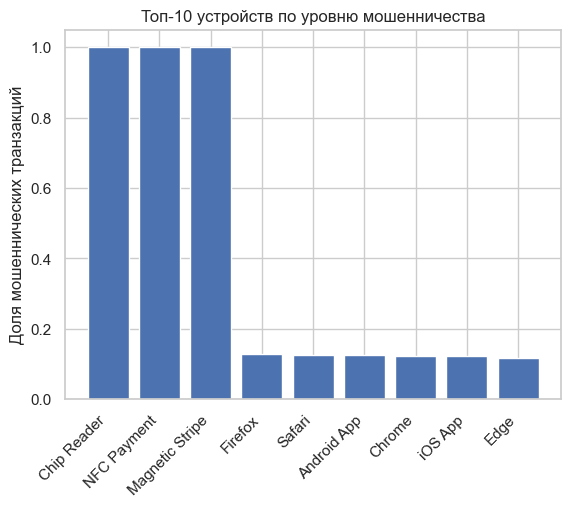

In [18]:
fraud_by_device = df_trans.groupby('device')['is_fraud'].mean().sort_values(ascending=False).head(10)
plt.figure()
plt.bar(fraud_by_device.index, fraud_by_device.values)
plt.title("Топ-10 устройств по уровню мошенничества")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Доля мошеннических транзакций")
plt.show()

Устройства типа "Chip Reader", "NFC Payment", "Magnetic Stripe" показывают максимальный уровень фрода (100%). Среди браузеров и приложений наиболее подозрителен, хоть и незначительно Firefox. Это означает, что для бизнеса важно контролировать физические устройства и устройства ввода, а также отслеживать подозрительные браузеры/приложения для анализа паттернов мошенничества.

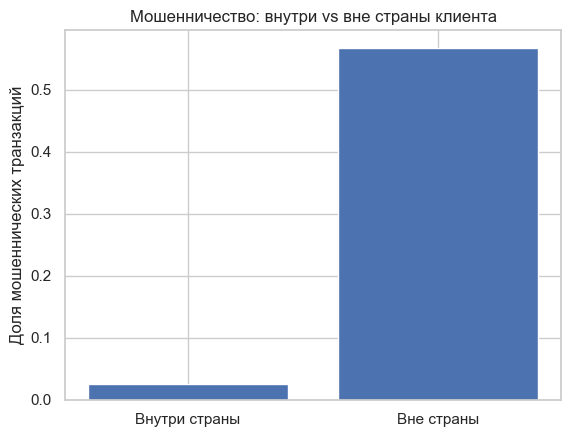

In [26]:
fraud_outside = df_trans.groupby('is_outside_home_country')['is_fraud'].mean()
plt.figure()
plt.bar(['Внутри страны','Вне страны'], fraud_outside.values)
plt.title("Мошенничество: внутри vs вне страны клиента")
plt.ylabel("Доля мошеннических транзакций")
plt.show()

Доля мошенничества за пределами домашней страны в разы выше, чем внутри. Это универсальный триггер для antifraud: все кросс-граничные транзакции должны быть под особым контролем, вплоть до обязательной проверки при превышении лимитов.

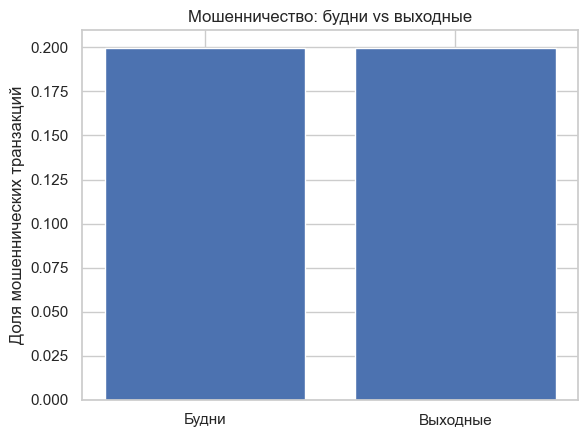

In [32]:
weekend_fraud = df_trans.groupby('is_weekend')['is_fraud'].mean()
plt.figure()
plt.bar(['Будни','Выходные'], weekend_fraud.values)
plt.title("Мошенничество: будни vs выходные")
plt.ylabel("Доля мошеннических транзакций")
plt.show()

Практически нет разницы между буднями и выходными по доле фрода. Это значит, что мошенники активны всегда

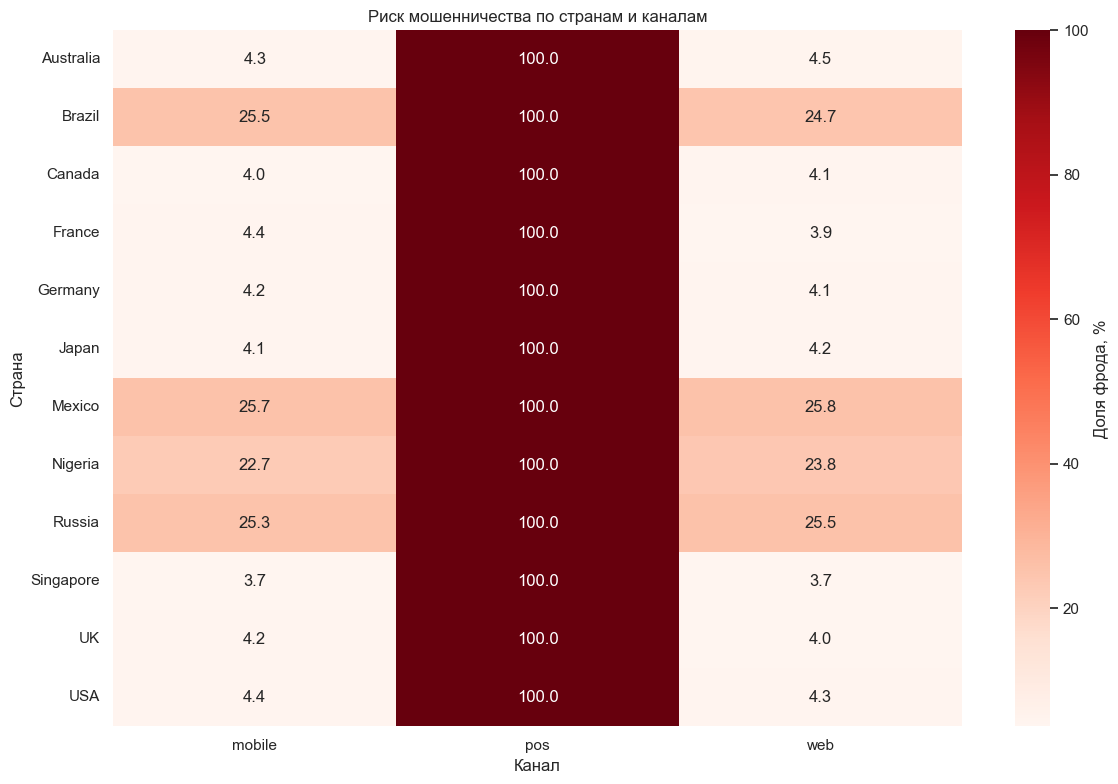

In [37]:
# Сводная таблица: риск мошенничества по стране и каналу
fraud_country_channel = df_trans.pivot_table(
    index='country',
    columns='channel',
    values='is_fraud',
    aggfunc='mean'
).sort_values('pos', ascending=False)  # сортируем по POS

plt.figure(figsize=(12, 8))
sns.heatmap(
    fraud_country_channel * 100,
    annot=True, fmt=".1f", cmap="Reds", cbar_kws={'label': 'Доля фрода, %'}
)
plt.title("Риск мошенничества по странам и каналам")
plt.ylabel("Страна")
plt.xlabel("Канал")
plt.tight_layout()
plt.show()

- POS (физический терминал): во всех странах доля фрода достигает 100% — это явный сигнал аномалии в данных, или индикатор, что все подозрительные POS-операции были размечены как фрод.

- Мобильный и web-каналы: самый высокий риск в Бразилии, Мексике, Нигерии, России (23–26%), остальные страны имеют <5%.

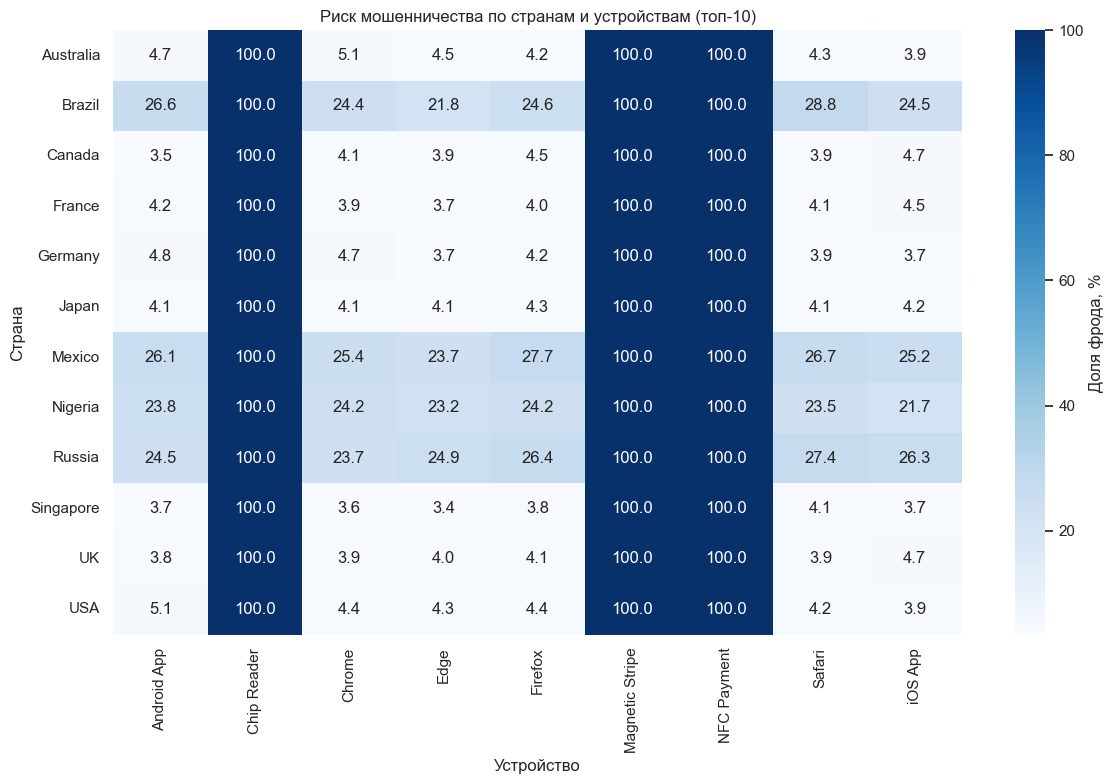

In [39]:
top_devices = df_trans['device'].value_counts().head(10).index
fraud_country_device = df_trans[df_trans['device'].isin(top_devices)].pivot_table(
    index='country',
    columns='device',
    values='is_fraud',
    aggfunc='mean'
).sort_values('Chip Reader', ascending=False)
plt.figure(figsize=(12, 8))
sns.heatmap(
fraud_country_device * 100,
annot=True, fmt=".1f", cmap="Blues", cbar_kws={'label': 'Доля фрода, %'}
)
plt.title("Риск мошенничества по странам и устройствам (топ-10)")
plt.ylabel("Страна")
plt.xlabel("Устройство")
plt.tight_layout()
plt.show()

#### По часам суток

- Физические методы оплаты (Chip Reader, Magnetic Stripe, NFC Payment) имеют 100% фрод во всех странах, что либо свидетельствует о качестве меток, либо о полном "захвате" терминалов мошенниками.

- Мобильные и браузерные приложения: повышенный риск в Бразилии, Мексике, Нигерии, России.

- В развитых странах (США, Европа) риск для приложений и браузеров стабильно низок (3-5%).

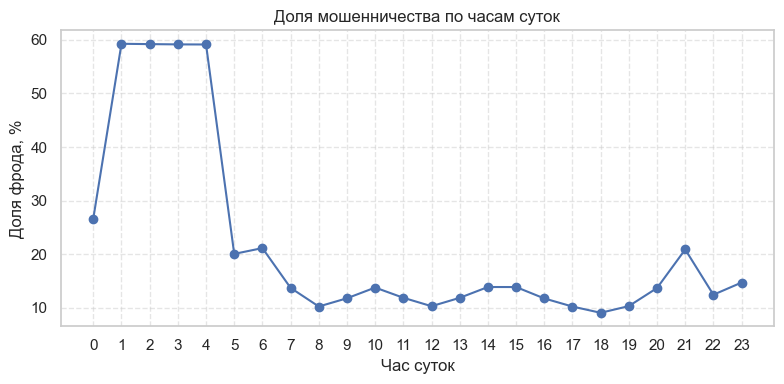

In [40]:
# Извлекаем час
df_trans['hour'] = df_trans['timestamp'].dt.hour

# Риск фрода по часам
fraud_by_hour = df_trans.groupby('hour')['is_fraud'].mean()

plt.figure(figsize=(8,4))
plt.plot(fraud_by_hour.index, fraud_by_hour.values * 100, marker='o')
plt.title("Доля мошенничества по часам суток")
plt.xlabel("Час суток")
plt.ylabel("Доля фрода, %")
plt.xticks(range(0,24))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

- Самые высокие пики фрода — ночью (1:00–4:00), более 50% всех операций в эти часы мошеннические.

- Днём риск заметно падает и держится на среднем уровне (10–20%), есть небольшой всплеск вечером.

- В ночные часы рекомендуется усиливать онлайн-мониторинг, автоматизировать реагирование и даже временно ограничивать лимиты для клиентов из зон риска.

- ___По дням недели___

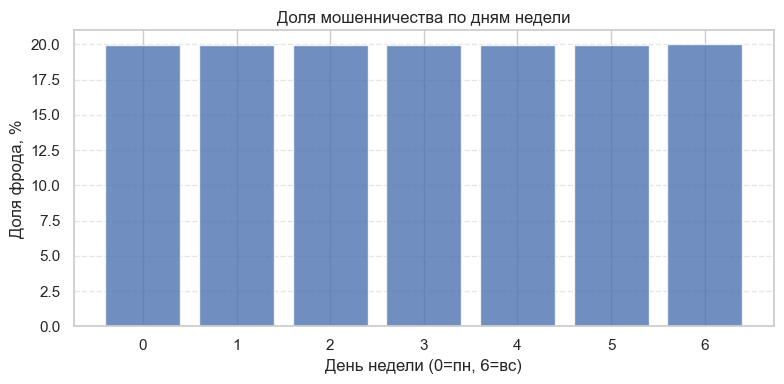

In [42]:
df_trans['weekday'] = df_trans['timestamp'].dt.weekday

fraud_by_wd = df_trans.groupby('weekday')['is_fraud'].mean()

plt.figure(figsize=(8,4))
plt.bar(fraud_by_wd.index, fraud_by_wd.values * 100, alpha=0.8)
plt.title("Доля мошенничества по дням недели")
plt.xlabel("День недели (0=пн, 6=вс)")
plt.ylabel("Доля фрода, %")
plt.xticks(range(7))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Доля фрода распределена равномерно по дням недели, без ярко выраженных всплесков.

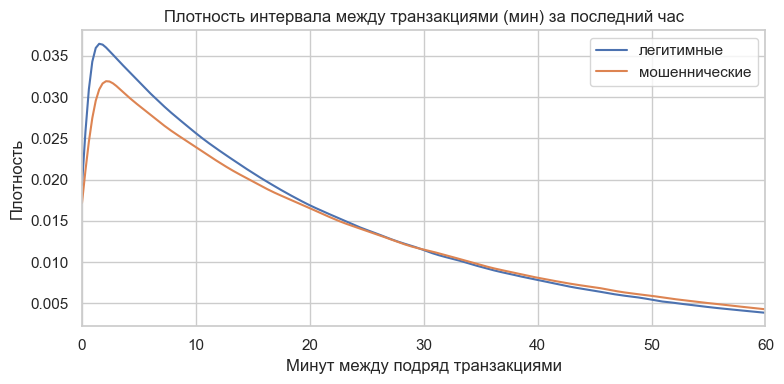

In [43]:
# Сортируем и считаем дельту между транзакциями одного клиента
df_trans = df_trans.sort_values(['customer_id','timestamp'])
df_trans['prev_ts'] = df_trans.groupby('customer_id')['timestamp'].shift(1)
df_trans['delta_min'] = (df_trans['timestamp'] - df_trans['prev_ts']).dt.total_seconds() / 60

# Сравним распределения для фрода vs не-фрода
plt.figure(figsize=(8,4))
sns.kdeplot(
    data=df_trans[df_trans['is_fraud']==0], x='delta_min',
    clip=(0, 60), label='легитимные', bw_adjust=0.5
)
sns.kdeplot(
    data=df_trans[df_trans['is_fraud']==1], x='delta_min',
    clip=(0, 60), label='мошеннические', bw_adjust=0.5
)
plt.xlim(0, 60)
plt.title("Плотность интервала между транзакциями (мин) за последний час")
plt.xlabel("Минут между подряд транзакциями")
plt.ylabel("Плотность")
plt.legend()
plt.tight_layout()
plt.show()

Распределение у фрода всё же смещено влево — признак может быть полезен для ML-модели

In [46]:
df_trans.head()

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,...,last_hour_unique_countries,last_hour_max_single_amount,date,rate,amount_usd,amount_range,hour,weekday,prev_ts,delta_min
3598,TX_5c7afc32,CUST_10000,4783025707700318,2024-09-30 00:42:09.333221,Retail,physical,IKEA,800.41,EUR,France,...,12,1.290053e+06,2024-09-30,0.895591,716.839824,100–1k,0,0,NaT,NaN
6854,TX_539390a9,CUST_10000,4783025707700318,2024-09-30 01:12:10.217450,Healthcare,medical,Local Hospital,571.91,EUR,France,...,10,8.126075e+05,2024-09-30,0.895591,512.197329,100–1k,1,0,2024-09-30 00:42:09.333221,30.014737
32015,TX_46fdbb94,CUST_10000,4783025707700318,2024-09-30 04:00:01.413084,Travel,airlines,American Airlines,1397.02,EUR,France,...,12,4.092679e+06,2024-09-30,0.895591,1251.158245,1k–10k,4,0,2024-09-30 01:12:10.217450,167.853261
32887,TX_785e54af,CUST_10000,4783025707700318,2024-09-30 04:05:50.354900,Healthcare,medical,Urgent Care,3799.41,BRL,Brazil,...,12,1.290053e+06,2024-09-30,5.434649,20648.458503,>10k,4,0,2024-09-30 04:00:01.413084,5.815697
37296,TX_eee6613d,CUST_10000,4783025707700318,2024-09-30 04:35:41.220854,Gas,local,Truck Stop,615.71,EUR,France,...,10,8.126075e+05,2024-09-30,0.895591,551.424205,100–1k,4,0,2024-09-30 04:05:50.354900,29.847766


In [48]:
# Групповые сводки по фроду
agg = df_trans.groupby('is_fraud').agg({
    'last_hour_num_transactions':'mean',
    'last_hour_total_amount':'mean',
    'last_hour_unique_merchants':'mean',
    'last_hour_unique_countries':'mean',
    'last_hour_max_single_amount':'mean'
}).rename(index={0:'Легитимные',1:'Мошеннические'})

display(agg)


,last_hour_num_transactions,last_hour_total_amount,last_hour_unique_merchants,last_hour_unique_countries,last_hour_max_single_amount
is_fraud,,,,,
Легитимные,408.262533,1.985784e+07,79.916723,10.650769,1.719987e+06
Мошеннические,412.670479,2.015500e+07,80.445120,10.710001,1.752255e+06


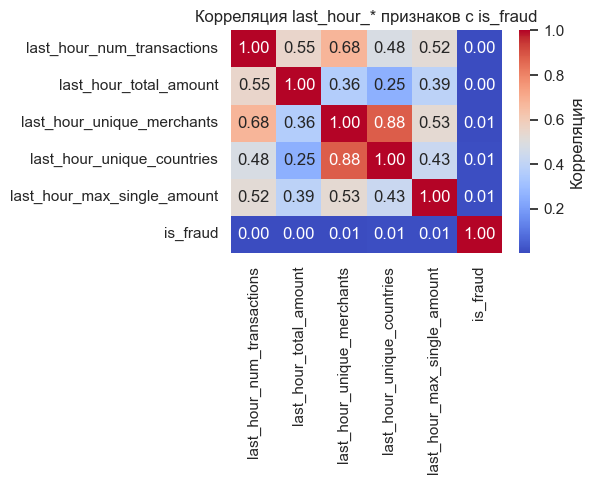

In [49]:
plt.figure(figsize=(6,5))
corr = df_trans[[
    'last_hour_num_transactions',
    'last_hour_total_amount',
    'last_hour_unique_merchants',
    'last_hour_unique_countries',
    'last_hour_max_single_amount',
    'is_fraud'
]].corr()

sns.heatmap(
    corr, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar_kws={'label':'Корреляция'}
)
plt.title("Корреляция last_hour_* признаков с is_fraud")
plt.tight_layout()
plt.show()

Предполагалось, что у мошенников будет заметно больше операций/денег за последний час, но в средних это почти не проявилось

Из-за огромных чисел (сотни транзакций и миллионы долларов) небольшие различия теряются в средних.
Корреляция в таком случае близка к нулю, хотя на хвостах распределения (в редких «спуртах») она может быть высокой.

## 📊 Итоговые выводы EDA и основные закономерности

**1. Общая сумма:**
- Наибольшее количество операций содержится в диапазоне 100–1000 USD, однако процент фродовых операция в этом сегменте минимален.
- На маленьких платежах (0-100 USD) lоля мошенничества максимальна (41,7%), но абсолютный вклад этой группы в общую сумму незначителен.
- Самый тревожный диапазон свыше 10 000 USD, так как сумма операций максимальна (более 3,3 млн), и риск мошенничества высок (30%). Это ключевая зона для ручной проверки и применения строгих правил.

**2. Страны и валюты:**  
- Основной объём транзакций сосредоточен в странах с развивающимися рынками (Nigeria, Brazil, Russia, Mexico), а не только в развитых экономиках.  
- Наибольшая доля мошенничества приходится на Мексику, Россию, Бразилию и Нигерию (до 35-40%), а в развитых странах она заметно ниже.

**3. Категории и каналы:**  
- Категориальный признак "продавец" для фрода менее информативен — доля мошенничества примерно одинакова по категориям.
- Самый высокий риск — на POS-устройствах и физических методах оплаты (100% фрода), особенно в ряде стран, но это может быть особенностью меток данных.
- Для web и mobile уровень фрода зависит от страны: в Бразилии, Мексике и Нигерии — более 20%, в США, Европе и Японии — менее 5%.

**4. Время и устройства:**  
- Максимальные пики мошенничества наблюдаются ночью (1–4 ч.), днём риск заметно ниже.
- День недели не влияет на фрод — атаки происходят равномерно.
- Среди устройств наибольший риск у физ. терминалов, а из софта — у Android App и Firefox в «горячих» странах.

**5. Активность за последний час (last_hour_activitу):**  
- В среднем разница между фродом и легитимом невелика. Однако гипотеза: "аномальный всплеск активности за час" требует дополнительного исследования на хвостах распределения или после нормализации.
- Для бизнес-правил и моделей рекомендуется использовать не абсолютные значения, а относительные фичи (например, прирост активности относительно типичного профиля клиента).

---

### 💡 Ключевые продуктовые и технические гипотезы

- **Локальные antifraud-правила**: усиленная верификация для POS и мобильных/web-каналов в Бразилии, Нигерии, Мексике, России.
- **Режим контроля ночью**: увеличить скоринг/ограничить лимиты на ночные операции, особенно в странах риска.
- **Агрегации для фичей ML**: использовать агрегаты за час, но через нормализацию и лог-трансформации; строить кросс-признаки (например, "всплеск активности + вне страны").
- **UX-оптимизация**: для постоянных клиентов с привычным паттерном — снижать число лишних проверок, минимизируя фолс-позитивы.
- **Требуется дальнейший анализ**: изучить хвосты распределения активности, провести фиче-инжиниринг на основе индивидуальных профилей.

---

_Все выявленные закономерности станут основой для постановки продуктовых гипотез, построения бизнес-правил и обучения antifraud ML-моделей._
